In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid

from helpers import plot_losses

In [3]:
def run_logistic(A, y, param, logging=False):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=logging)
    if logging:
        print()
        print('{0} - score: {1:.4f}'.format(param, m.score(A, y)))
    return list_losses

In [4]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [5]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [6]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load Higgs Boson dataset

In [7]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [8]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.743172
Final loss: 0.50647033460686


### Computing with Decentralized SGD

In [9]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 30
params_disconnected = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.05, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=2048,
                           method='plain', topology='disconnected', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

losses_disconnected = run_logistic(A, y, params_disconnected, logging=True)

length of indices: 2049
length of last machine indices: 122
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [122/122]      14s       0.5898    0.7094        
[2/5]      [122/122]      28s       0.5880    0.7133        
[3/5]      [122/122]      41s       0.5877    0.7154        
[4/5]      [122/122]      54s       0.5895    0.7172        
[5/5]      [122/122]      67s       0.5901    0.7186        

{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 2048, 'method': 'plain', 'topology': 'disconnected', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30, 'tol': 1e-10} - score: 0.7186


In [10]:
params_complete = params_disconnected.copy()
params_complete['topology'] = 'complete'
losses_complete = run_logistic(A, y, params_complete, logging=True)

length of indices: 2049
length of last machine indices: 122
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [122/122]      13s       0.5871    0.7115        
[2/5]      [122/122]      27s       0.5796    0.7155        
[3/5]      [122/122]      40s       0.5755    0.7182        
[4/5]      [122/122]      53s       0.5727    0.7201        
[5/5]      [122/122]      66s       0.5708    0.7212        

{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 2048, 'method': 'plain', 'topology': 'complete', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30, 'tol': 1e-10} - score: 0.7212


### Barbell and Path topologies

In [11]:
params_barbell = params_disconnected.copy()
params_barbell['topology'] = 'barbell'
losses_barbell = run_logistic(A, y, params_barbell, logging=True)

length of indices: 2049
length of last machine indices: 122
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [122/122]      13s       0.5871    0.7115        
[2/5]      [122/122]      26s       0.5796    0.7155        
[3/5]      [122/122]      39s       0.5755    0.7182        
[4/5]      [122/122]      52s       0.5727    0.7201        
[5/5]      [122/122]      65s       0.5707    0.7213        

{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 2048, 'method': 'plain', 'topology': 'barbell', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30, 'tol': 1e-10} - score: 0.7213


In [12]:
params_path = params_disconnected.copy()
params_path['topology'] = 'path'
losses_path = run_logistic(A, y, params_path, logging=True)

length of indices: 2049
length of last machine indices: 122
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [122/122]      13s       0.5871    0.7112        
[2/5]      [122/122]      26s       0.5798    0.7154        
[3/5]      [122/122]      40s       0.5756    0.7180        
[4/5]      [122/122]      53s       0.5729    0.7202        
[5/5]      [122/122]      66s       0.5709    0.7215        

{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 2048, 'method': 'plain', 'topology': 'path', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30, 'tol': 1e-10} - score: 0.7215


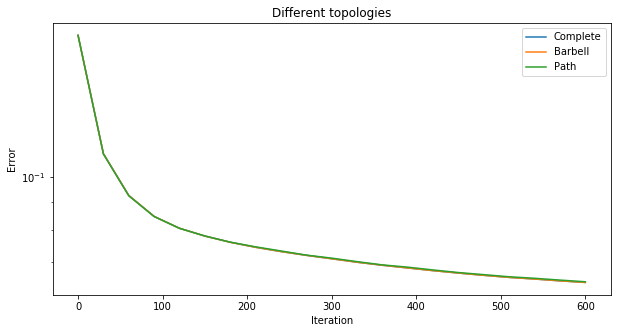

In [13]:
iterations_indices = np.arange(0, losses_complete.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete, losses_barbell, losses_path)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Barbell", "Path"], title="Different topologies")